**Yixuan Qiu**

Spring 2020

CS 251: Data Analysis and Visualization

Project 5: Clustering

In [34]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from scipy.stats import multivariate_normal
from matplotlib.image import imread
import io
from PIL import Image
import time

import kmeans
import em

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 5) EM Algorithm

### 5a) Implement multivariate Gaussian (`gaussian`)

**LA section:** Implement from scratch (i.e. using common numpy math functions and `np.linalg.det` and `np.linalg.inv`)

**Non-LA section:** Make a wrapper for Scipy stats multivariate normal pdf function.

In [2]:
# Test 1: 2D data
np.random.seed(0)
test_xy = np.random.randn(5,2)
test_mu = np.random.uniform(size=(2,))
test_sigma = np.array([[2, 1.5], [1.5, 2]])

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_xy, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.06237 0.02907 0.00424 0.08301 0.08269]')

Your Gaussian PDF evaluated that the test points:
[0.06237 0.02907 0.00424 0.08301 0.08269]
It should be
[0.06237 0.02907 0.00424 0.08301 0.08269]


In [3]:
# Test 2: 4-dimensional data
np.random.seed(0)
test_10 = np.random.randn(5,4)
test_mu = np.random.uniform(size=(4,))
test_sigma = np.random.uniform(size=(4,4))
test_sigma = test_sigma.T @ test_sigma

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_10, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.      0.      0.      0.13288 0.     ]')

Your Gaussian PDF evaluated that the test points:
[0.      0.      0.      0.13288 0.     ]
It should be
[0.      0.      0.      0.13288 0.     ]


### 5b) Implement EM algorithm

Implement each of the following core methods in `em.py`. 

- `initialize`: Initialize cluster means, variance, and the probability that data samples belong to each of the clusters.
- `e_step`: Expectation step of EM algorithm. Compute probability each datapoint belongs to each cluster.
- `m_step`: Maximization step of EM algorithm. Compute each Gaussian cluster's mean and covariance matrix based on data assigned to each cluster.
- `log_likelihood`: Used in EM to monitor clustering progress and detect convergence. Log of sum of probabilities of all data points assigned to all clusters.
- `cluster`: Method that runs EM algorithm.

**E-Step equations:**

Compute the *responsibilities* ($w_{ci}$): the probability that data sample $i$ belongs to cluster $c$.

It can be computed in two stages: Determine $\hat{w}_{ci}$ then ${w}_{ci}$. $$\hat{w}_{ci} = \pi_c \times G\left (\mathbf{data}, \vec{\mu}_c, \mathbf{\Sigma_c}  \right )$$ Above, $\pi_c$ is the proportion of data samples that are associated with cluster $c$ (more on this below), $G(\cdot,\cdot,\cdot)$ is a multivariate Gaussian (representing cluster $c$), $\vec{\mu}_c$ is the mean (*centroid*) of that Gaussian cluster $c$, and $\mathbf{\Sigma_c}$ is the covariance matrix for cluster $c$.$${w}_{ci} = \frac{\hat{w}_{ci}}{\sum_{d=1}^{k}\hat{w}_{di}}$$


**M-Step equations:**

The job of the M-step is to compute the Gaussian cluster centroids ($\vec{\mu}_c$), Gaussian cluster covariance matrices ($\mathbf{\Sigma}_c$), and proportion of data samples that are associated each cluster ($\pi_c$).

$\pi_c$ is the average responsibility of all data samples with respect to each cluster $c$: $$\pi_c = \frac{1}{N}\sum_{j=1}^N w_{cj}$$
Note that above $N$ is the number of data samples. $$\vec{\mu}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \times \vec{\text{data}}_j $$
Above $R_c$ is defined as the sum of the responsibilities of all data samples belonging to one cluster: $R_c = \sum_{j=1}^N {w}_{cj}$.

Finally, the covariance of each cluster $\mathbf{\Sigma}_c$ is computed as: $$\mathbf{\Sigma}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \left ( \vec{\text{data}}_j - \vec{\mu}_c \right )^T \left ( \vec{\text{data}}_j - \vec{\mu}_c \right ) $$
where above $T$ indicates transpose.

**Log-likelihood:**

$$ll = \sum_{i=1}^N Log \left [\sum_{c=1}^k \pi_c f_c \left ( \vec{x}_i; \vec{\mu}_c, \Sigma_c \right ) \right]$$

where $f_c(\cdot)$ is the Gaussian distribution.

#### Test `e_step` (and `initialize`)

In [4]:
np.random.seed(0)

test_init_centroids = np.array([[1.76405, 0.40016], [0.97874, 2.24089]])

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initalize(test_k)
em_test.centroids = test_init_centroids
test_probs = em_test.e_step()
print(f'After 1 E step, your test responsibilities are:\n{test_probs}\nand should be:\n[[0.88106 0.11894 0.99024 0.91517 0.62642]\n\
 [0.11894 0.88106 0.00976 0.08483 0.37358]]')

After 1 E step, your test responsibilities are:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]
and should be:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]


#### Test `m_step`

In [5]:
np.random.seed(0)

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initalize(test_k)
em_test.e_step()
test_m, test_s, test_pi = em_test.m_step()

print(f'After 1 EM iteration, your means are\n{test_m}\n')
print(f'After 1 EM iteration, your covariance matrix is\n{test_s}\n')
print(f'After 1 EM iteration, your pi array is\n{test_pi}\n')

After 1 EM iteration, your means are
[[ 1.22452 -0.06511]
 [ 0.77131  1.46643]]

After 1 EM iteration, your covariance matrix is
[[[ 0.52278 -0.22681]
  [-0.22681  0.50843]]

 [[ 0.3101   0.21107]
  [ 0.21107  0.92664]]]

After 1 EM iteration, your pi array is
[0.70637 0.29363]



The above test should output:

    After 1 EM iteration, your means are
    [[ 1.22452 -0.06511]
     [ 0.77131  1.46643]]

    After 1 EM iteration, your covariance matrix is
    [[[ 0.52278 -0.22681]
      [-0.22681  0.50843]]

     [[ 0.3101   0.21107]
      [ 0.21107  0.92664]]]

    After 1 EM iteration, your pi array is
    [0.70637 0.29363]

#### Test `log_likelihood`

In [6]:
print(f'After running 1 EM iteration (above test code), your likelihood is\n{em_test.log_likelihood()}\nand it should be\n-11.394389039914211')

After running 1 EM iteration (above test code), your likelihood is
-11.394389039914211
and it should be
-11.394389039914211


#### Test `cluster`

Use pandas to load in the `super_simple` dataset. Assign it to the variable `super_simple` then run the following test code to create a plot of your Gaussian clusters. It should look like the following image.

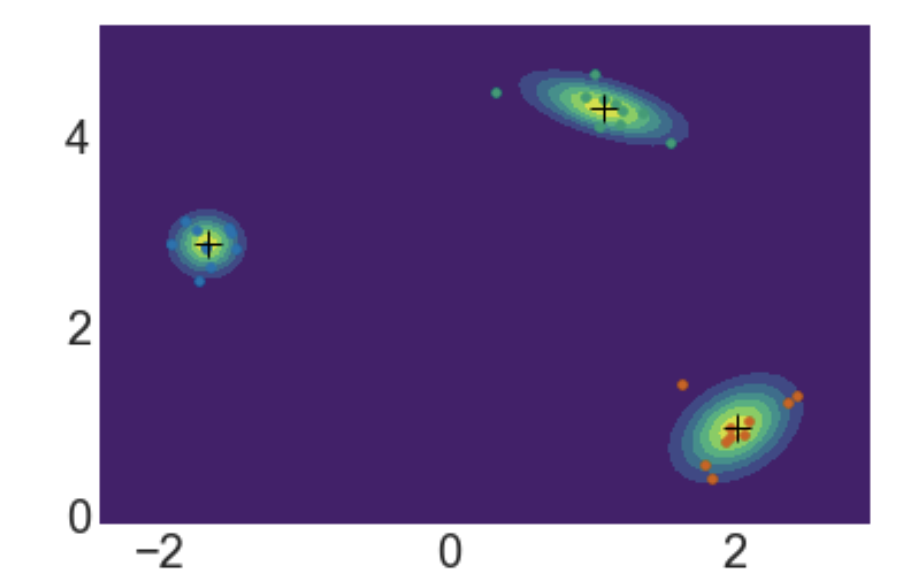

current iteration: 1
current log likelihood: -33.55070721142693
current iteration: 2
current log likelihood: -23.149219099740083
current iteration: 3
current log likelihood: -23.149219099702236
total number of iterations: 3


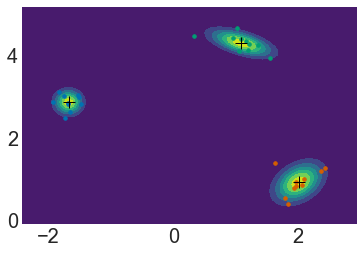

In [32]:
np.random.seed(0)

df = pd.read_csv('data/super_simple.csv')
super_simple = df.to_numpy()

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)

simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=True)
simple_test.plot_clusters(super_simple)

### 5c) EM algorithm animation visualization

- Add an optional parameter to `EM::cluster` called `animate`. By default, make it set to False.
- In the main EM loop, after performing a full iteration of EM, call the `plot_clusters` method (if `animate` is true). Immediately before your method call, add the code: `clear_output(wait=True)`. Immediately after, add the code: `plt.pause(0.1)` (The parameter, 0.1 in this case, is the wait time in seconds between plot updates in the animation).

Running this test code, should produce a (**very cool**) animation showing the EM algorithm unfolding over time. You should see if overcome a challenging initial condition.

Here is an image of what the final clustering should look like:

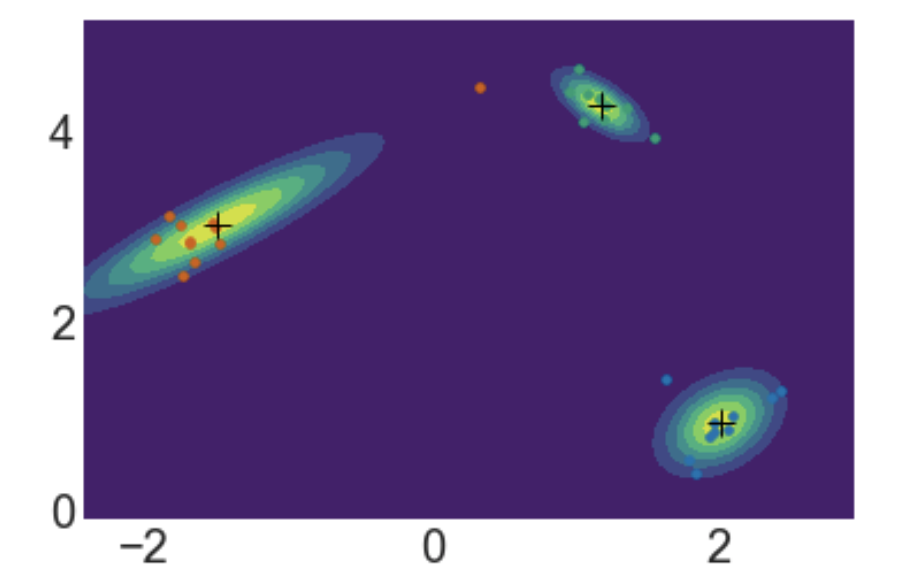

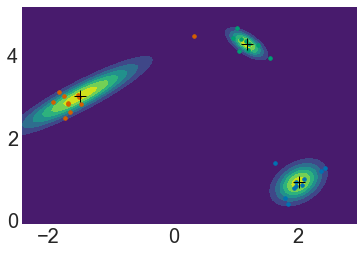

total number of iterations: 25


In [36]:
np.random.seed(4)

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)
simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, animate=True)

### 5d) Outlier detection with EM algorithm

Because the EM algorithm computes the probability that each data sample belongs to each cluster, it can be used to detect outliers in the dataset.

- Implement `find_outliers` in `em.py`.
- Run the following code to find outliers in the `super_simple` dataset (defined as samples belonging to a cluster that have probability < 0.5 here).

In [48]:
# Find outliers in all 3 clusters
outliers = simple_test.find_outliers(thres=0.5)
print(f'Sample indices of your outliers are\n{outliers}\nand they should be\n[(array([20, 26]),), (array([], dtype=int64),), (array([ 0, 18, 28]),)]')

Sample indices of your outliers are
[array([20, 26]), array([], dtype=float64), array([ 0, 18, 28])]
and they should be
[(array([20, 26]),), (array([], dtype=int64),), (array([ 0, 18, 28]),)]


- In the cell below, superimpose a plot on the cluster plot, indicating the outliers that you found with star markers (make them large so that they stand out). It should look like the following image:

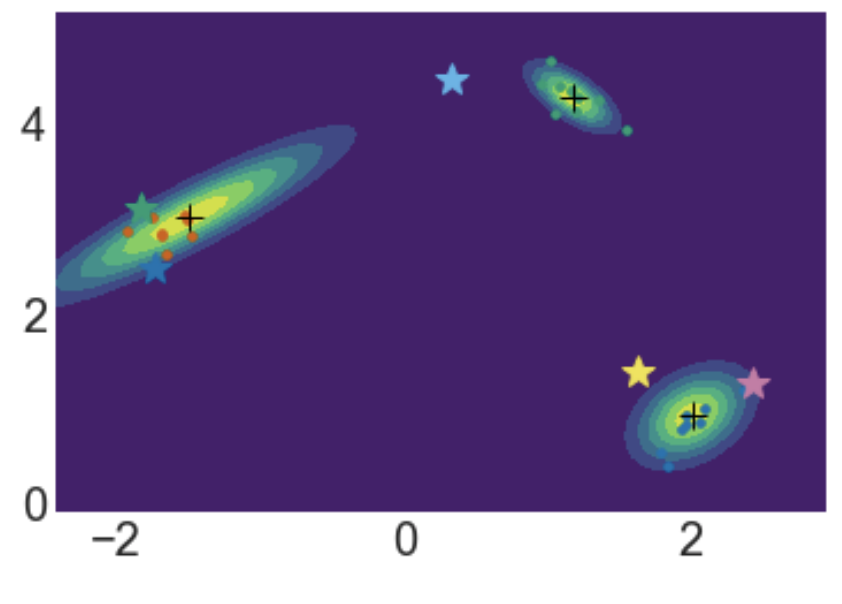

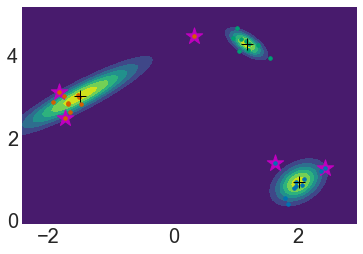

In [49]:
simple_test.plot_clusters(super_simple, show=False)

for arr in outliers:
    for i in range(len(arr)):   
        plt.scatter(super_simple[arr[i]][0], super_simple[arr[i]][1], s = 300, c = 'm', marker = '*')
plt.show()

## Task 6) Cluster a dataset of your choice with EM algorithm

- Select a 2D dataset (one we've worked with before or a new one of your choice).
    - You may select a higher dimensional dataset, but only run EM on 2 variables **that make sense (see next item)**
    - You may select a higher dimensional dataset and run PCA to reduce the dimensionality to 2D.
- Formulate a question (see question below) that could be addressed by cluster analysis.
- Import/preprocess to prepare the data for clustering by the EM algorithm.
- Analyze the data. Minimally, this should include:
    - Select a k that makes sense to you (you may explore this more rigorously as an extension).
    - Plot of the 2D data clustered.
    - Detect and show outliers
    - Report the final log likelihood of the clustering.

**Question 5:** What dataset did you select for clustering?

**Answer 5:**<br>
iris dataset

total number of iterations: 53
final log likelihood: -135.3160657550113


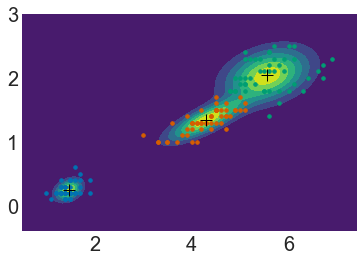

In [6]:
np.random.seed(0)

iris_df = pd.read_csv('data/iris.csv')
iris = iris_df[['petalLength','petalWidth']].to_numpy()

iris_k = 3
iris_max_iter = 100

iris_test = em.EM(iris)

iris_test.cluster(k=iris_k, max_iter=iris_max_iter, verbose=False)
ll = iris_test.log_likelihood()
print("final log likelihood:", ll)
iris_test.plot_clusters(iris)

In [51]:
# Find outliers in all 3 clusters
outliers = iris_test.find_outliers(thres=0.5)

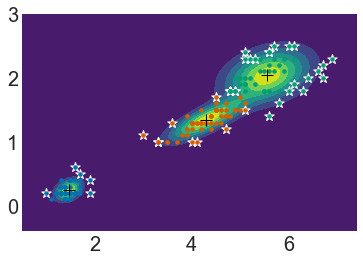

In [54]:
iris_test.plot_clusters(iris, show=False)

for arr in outliers:
    for i in range(len(arr)):   
        plt.scatter(iris[arr[i]][0], iris[arr[i]][1], s = 100, c = 'w', marker = '*')
plt.show()

**Question 6:** Which two variables did you select for clustering? What question are you exploring, which you believe could be addressed by a cluster analysis?

**Answer 6:**<br>
Variables: Petal length, petal width.<br>

Question: How representative are petal length and petal width for classification of species?<br>

The three clusters capture the three species--setosa, versicolor, and virginica--in the iris dataset. And the two variables petal length and petal width are reflective enough to tell us the difference in the three species.<br>
Also, petal length and petal width have a positive correlation.

**Question 7:** What is your interpretation of what the outliers that you detected mean in the context of your dataset?

**Answer 7:**<br>
The species can roughly separated by petal size, but a more accurate classification must refer to other features as well. Otherwise, there are outliers that are hard to classify based only on petal size.

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Make an `elbow_plot` for EM algorithm

- Test out and explain results of your `elbow_plot` method on a dataset.

NOTE: Log likelihood is negative and higher is better. Factor this into your interpretation.

I made an elbow_plot method in EM that makes an elbow plot with cluster number (k) on x axis, the final log likelihood on y axis.<br>
I chose to plot the five blobs dataset which is supposed to have five clusters.<br>
And I set the maximum number of clusters to be 10.

In [30]:
fb_df = pd.DataFrame(pd.read_csv('data/five_blobs.csv'))
fb_arr = fb_df.to_numpy()
five_blobs = em.EM(fb_arr)

total number of iterations: 2
total number of iterations: 14
total number of iterations: 7
total number of iterations: 21
total number of iterations: 15
total number of iterations: 100
total number of iterations: 100
total number of iterations: 100
total number of iterations: 100


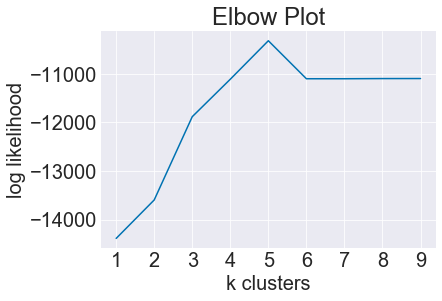

In [2]:
five_blobs.elbow_plot(10)

As shown in the plot, when k < 5, log likelihood gets higher. Log likelihood is negative and higher is better.<br>
At k=5, the curve starts to plateau, which means after k=5, the log likelihood gets diminishing returns.<br>
So, 5 is a reasonable number of clusters to initialize, which coincides with our assumption.

### 2) Better initial conditions

- EM has the same centroid initialization problem as K-means. Implement a version of K-means++ initialization for EM. Analyze the differences vs. the random initialization scheme.

I add a boolean parameter plusplus in the cluster method and initialize method to control the initialization scheme.<br>
The default value of plusplus is False, in which case the centroids get initialized randomly.<br> 
If plusplus is set to True, then the program will run an EM version of K-means++ initialization.

In [43]:
np.random.seed(3)

simple_k = 5
simple_max_iter = 100

simple_test = em.EM(super_simple)
print("Initialize randomly:\n")
ll_hist_rand = simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, plusplus=False)
print("final log likelihood:", ll_hist_rand[-1])

Initialize randomly:

total number of iterations: 25
final log likelihood: -19.535831037581417


In [44]:
np.random.seed(3)
simple_test = em.EM(super_simple)
print("EM version of K-means++:\n")
ll_hist_plus = simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, plusplus=True)
print("final log likelihood:", ll_hist_plus[-1])

EM version of K-means++:

total number of iterations: 33
final log likelihood: -11.999716513906227


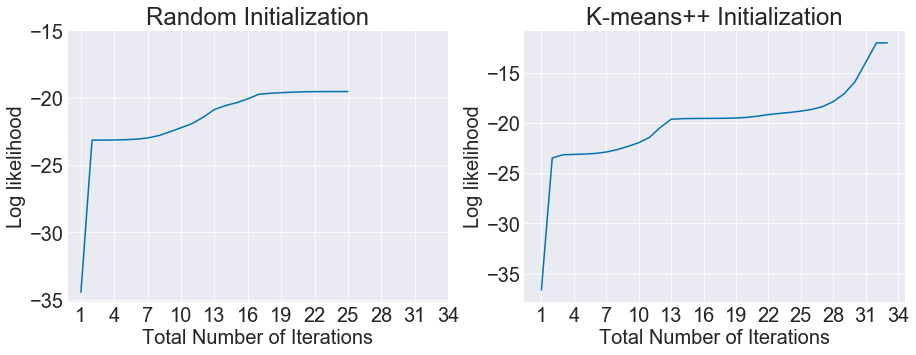

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(np.arange(1, 26), ll_hist_rand)
plt.xlabel('Total Number of Iterations')
plt.xticks(np.arange(1, 35, step=3))
plt.ylabel('Log likelihood')
plt.yticks(np.arange(-35, -10, step=5))
plt.title('Random Initialization')

plt.subplot(122)
plt.plot(np.arange(1, 34), ll_hist_plus)
plt.xlabel('Total Number of Iterations')
plt.xticks(np.arange(1, 35, step=3))
plt.ylabel('Log likelihood')
plt.yticks(np.arange(-35, -10, step=5))
plt.title('K-means++ Initialization')

plt.show()

I chose to cluster the super simple dataset into 5 clusters.<br>
The total number of iterations using the random initialization method is 25, whereas the total number of iterations using K-means++ is 33. K-means seemed to run more iterations.<br>
The final log likelihood for random is -19.5, while that for K-means++ is -12.0.<br>
Clearly, the EM version of K-means++ initialization generates a higher log likelihood, which means the clustering is better.

### 3) Image compression

- Run K-means on other images and quantify the reduction in space required to store each image (with different values of k).

To calculate each image's size, I used io package to make a function imageByteSize.

In [4]:
def imageByteSize(img):
    img_file = io.BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'jpeg')
    return img_file.tell()/1024

In [5]:
def flatten(img):
    '''Flattens `img` to N 1D vectors.
    For example, for an RGB image, `(num_rows, num_cols, rgb)` -> `(num_rows*num_cols, rgb)`.
    
    Parameters:
    -----------
    img: ndarray. shape=(num_rows, num_cols, rgb)
    
    Returns:
    -----------
    Flattened `img`. ndarray. shape=(num_rows*num_cols, rgb)
    '''
    num_rows, num_cols, rgb = img.shape
    flattened_img = img.reshape(num_rows*num_cols, rgb)
    return flattened_img

Number of Unique Colors: 57015
Image size: 32.0146484375 bytes


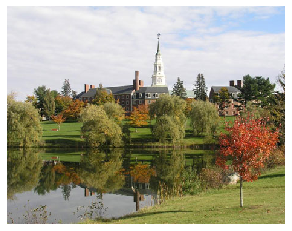

In [6]:
johnson = imread("data/johnson.jpeg")
plt.xticks([])
plt.yticks([])
plt.imshow(johnson)
img_size = imageByteSize(johnson)
unique_values, counts = np.unique(flatten(johnson).astype('uint8'), return_counts=True, axis=0)
print("Number of Unique Colors:", len(unique_values))
print("Image size:", img_size, "bytes")

The original image has 57015 unique colors and a size of 32 bytes.

#### 3 Unique Colors

Number of Unique Colors: 3

Unique RGB Values:
 [[ 78  70  35]
 [143 135  90]
 [222 224 232]]

Counts: [55085 49063 61452]

Image size: 27.3525390625 bytes


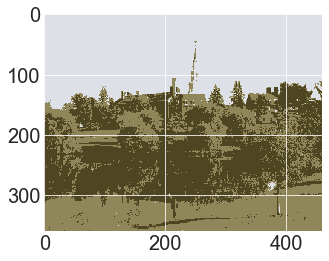

In [8]:
# k = 3
johnson_vec = flatten(johnson)
johnson_kmeans = kmeans.KMeans(johnson_vec)
johnson_kmeans.replace_color_with_centroid(k=3)
orig_johnson = johnson_kmeans.get_data().reshape(johnson.shape[0], johnson.shape[1], 3)
unique_values, counts = np.unique(flatten(orig_johnson).astype('uint8'), return_counts=True, axis=0)
print("Number of Unique Colors:", len(unique_values))
print("\nUnique RGB Values:\n", unique_values)
print("\nCounts:", counts)
img_size_3 = imageByteSize(orig_johnson)
print("\nImage size:", img_size_3, "bytes")
plt.imshow(orig_johnson.astype('uint8'))

When k=3, there are 3 unique colors:<br>
dark green: rgb(77, 70, 34); count: 54981<br>
olive-ish: rgb(143, 134, 90); count: 49165<br>
light gray: rgb(222, 224, 232); count: 61454<br>

Based on the counts of each color, gray occupies the majority of the compressed image, followed by dark green, which makes sense according to the above image.

The image with 3 clusters has a reduced size of 27.4 bytes.<br>
Compared to the original image size, the compressed one saves 14% of space.

#### 5 Unique Colors

Number of Unique Colors: 5

Unique RGB Values:
 [[ 58  55  27]
 [106  93  48]
 [146 136  77]
 [153 151 144]
 [222 225 233]]

Counts: [30170 33650 27984 12981 60815]

Image size: 29.55078125 bytes


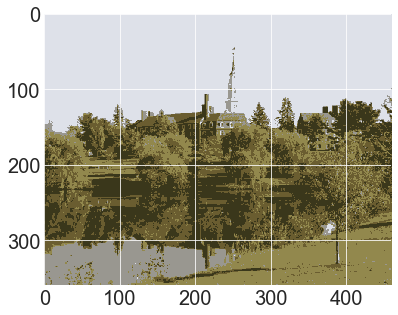

In [48]:
# k = 5
johnson_kmeans = kmeans.KMeans(johnson_vec)
johnson_kmeans.replace_color_with_centroid(k=5)
orig_johnson = johnson_kmeans.get_data().reshape(johnson.shape[0], johnson.shape[1], 3)
unique_values, counts = np.unique(flatten(orig_johnson).astype('uint8'), return_counts=True, axis=0)
print("Number of Unique Colors:", len(unique_values))
print("\nUnique RGB Values:\n", unique_values)
print("\nCounts:", counts)
img_size_5 = imageByteSize(orig_johnson)
print("\nImage size:", img_size_5, "bytes")
plt.imshow(orig_johnson.astype('uint8'))

There are 5 unique colors in the image:<br>
dark olive green: rgb(58, 55, 27); count: 30170<br>
brown-ish: rgb(106, 93, 48); count: 33650<br>
yellow-ish: rgb(146, 136, 77); count: 27984<br>
dark gray: rgb(153, 151, 144); count: 12981<br>
light gray: rgb(222, 225, 233); count: 60815<br>

Light gray, which is the sky, has the highest count.<br>
Dark gray, represents a small portion of the pond in the bottom left corner, has the lowest count.

The size of the iamge is 29.6 bytes, larger than the one with 3 clusters by 7.4%, smaller than the original by 7.5%.

#### Quantify Reduction in Image Size with Different Values of k

I want to record the number of unique colors, image size in memory with different values of k.

In [49]:
sizes = []
for i in range(3, 8):
    print("\nk =", i)
    johnson_kmeans = kmeans.KMeans(johnson_vec)
    johnson_kmeans.replace_color_with_centroid(k=i)
    orig_img = johnson_kmeans.get_data().reshape(johnson.shape[0], johnson.shape[1], 3)
    img_size = imageByteSize(orig_img)
    percent_red = (32 - img_size) / 32 * 100    # 32 is the original image size
    sizes.append(percent_red)
    print("Image size:", img_size, "bytes")
    print("% reduction:", percent_red, "%")


k = 3
Image size: 27.3642578125 bytes
% reduction: 14.4866943359375 %

k = 4
Image size: 30.6640625 bytes
% reduction: 4.1748046875 %

k = 5
Image size: 29.734375 bytes
% reduction: 7.080078125 %

k = 6
Image size: 29.8408203125 bytes
% reduction: 6.7474365234375 %

k = 7
Image size: 30.1328125 bytes
% reduction: 5.8349609375 %


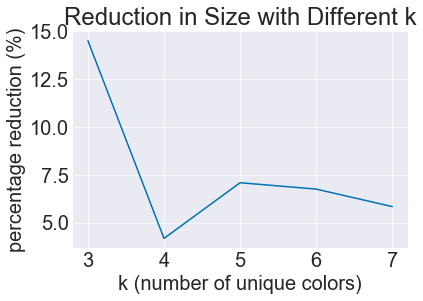

In [50]:
plt.plot(np.arange(3, 8), sizes)
plt.xticks(np.arange(3, 8))
plt.xlabel("k (number of unique colors)")
plt.ylabel("percentage reduction (%)")
plt.title("Reduction in Size with Different k")
plt.show()

As shown in the plot, the percentage reduction in image size overall decreases as number of unique colors increases.<br>
When k goes from 3 to 4, the percentage reduction drops dramatically. This might have something to do with the color attributes of the original image.<br>
Looking at the image of Johnson Pond, we tend to intuitively categorize it into 3 regions--the sky, trees, and the pond--each can be represented with a color.<br>
So when it has to divide the colors into 4 clusters, it is not as straightforward as when k=3, and thus not as space-efficient.<br>
There is a bump at k=5, perhaps due to a similar reason.

### 4) Detect number of clusters in other datasets

- Cluster other datasets and create elbow plots and/or silhouette plots to detect the number of clusters.

I chose the tips dataset to detect number of clusters.

total number of iterations: 2
total number of iterations: 19
total number of iterations: 50
total number of iterations: 100


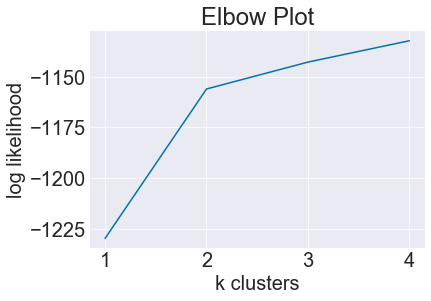

In [25]:
# np.random.seed(0)
tip_df = pd.DataFrame(pd.read_csv('data/tips.csv'))
tip = tip_df[['total_bill','tip']].to_numpy()
tip_test = em.EM(tip)
tip_test.elbow_plot(5)

Based on the elbow plot, I would choose k=2 which is at the point of plateau.

total number of iterations: 33
final log likelihood: -1156.01692495233
centroids: [[15.1149   2.4632 ]
 [27.13367  3.83998]]


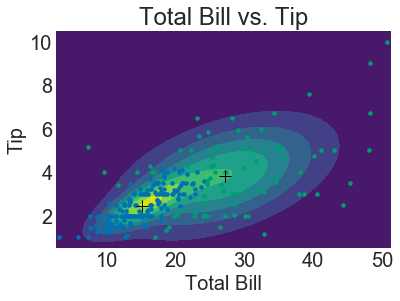

In [30]:
tip_k = 2
tip_max_iter = 100
tip_test.cluster(k=tip_k, max_iter=tip_max_iter, verbose=False)
ll = tip_test.log_likelihood()
print("final log likelihood:", ll)
print("centroids:", tip_test.centroids)
tip_test.plot_clusters(tip, xlabel="Total Bill", ylabel="Tip", title="Total Bill vs. Tip")

The two clusters have a lot of overlapping, and has something to do with sexes.<br>
Based on my previous exploration of the tips dataset, males pay more often than females.<br>
Consequently, the green cluster(lower left) represents female customers and the blue cluster(upper right) represents male customer.<br>
We can also deduce from the plot that tips is positively correlated with total bills.<br>
The centroid of the blue cluster is at (15.1, 2.5), and the centroid of the green cluster is at (27.1, 3.8), which represent the two groups of customers.<br>
2.5/15.1 = 16.6%<br>
3.8/27.1 = 14.0%<br>
Both groups give tip around 15%.

### 5) K-means vs. EM algorithm

- Compare the efficiency of K-means and EM. Create plots showing runtime, number of iterations, etc. Analyze / interpret the results.

I compared runtime and number of iterations for the super simple dataset using K-means and EM.

In [46]:
# K-means
simple_kmeans = kmeans.KMeans(super_simple)
kmeans_time = []
kmeans_num_iter = []
for i in range(2, 5):
    start = time.time()
    inertia, num_iter = simple_kmeans.cluster(k=i, tol=1e-5, max_iter=1000, init_method='random', verbose=False)
    end = time.time()
    kmeans_time.append(end - start)
    kmeans_num_iter.append(num_iter)

In [36]:
# EM
simple_em = em.EM(super_simple)
em_time = []
for i in range(2, 5):
    start = time.time()
    simple_em.cluster(k=i, max_iter=1000, stop_tol=1e-3, verbose=False, animate=False, plusplus=False)
    end = time.time()
    em_time.append(end - start)

total number of iterations: 25
total number of iterations: 13
total number of iterations: 17


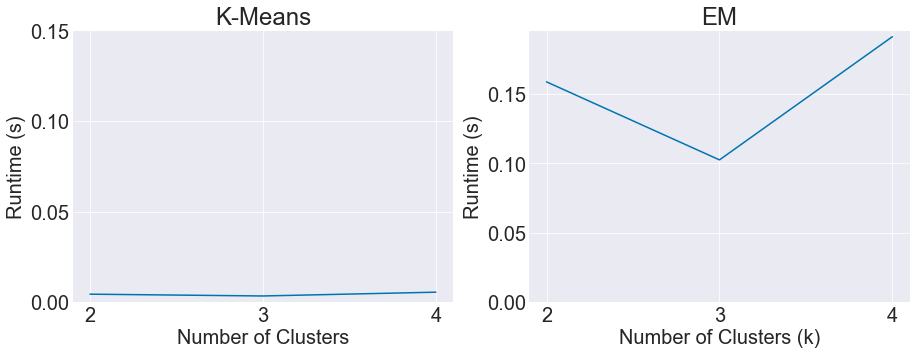

In [44]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(np.arange(2, 5), kmeans_time)
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(2, 5))
plt.ylabel('Runtime (s)')
plt.yticks(np.arange(0, 0.2, step = 0.05))
plt.title('K-Means')

plt.subplot(122)
plt.plot(np.arange(2, 5), em_time)
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(2, 5))
plt.ylabel('Runtime (s)')
plt.yticks(np.arange(0, 0.2, step = 0.05))
plt.title('EM')

plt.show()

K-means runs a lot faster than EM.

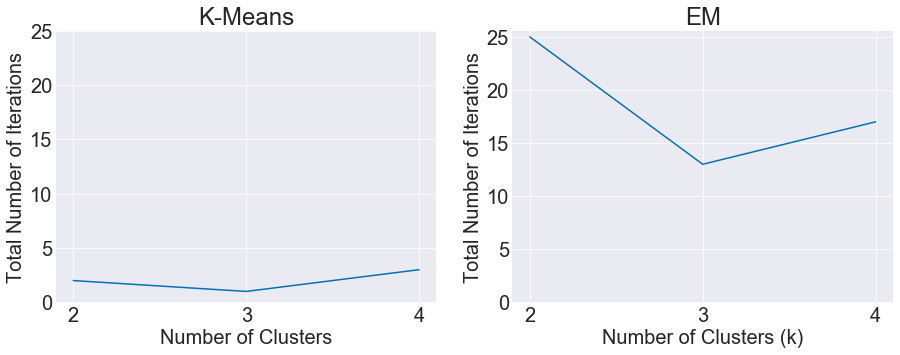

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(np.arange(2, 5), kmeans_num_iter)
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(2, 5))
plt.ylabel('Total Number of Iterations')
plt.yticks(np.arange(0, 30, step=5))
plt.title('K-Means')

plt.subplot(122)
plt.plot(np.arange(2, 5), [25, 13, 17])
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(2, 5))
plt.ylabel('Total Number of Iterations')
plt.yticks(np.arange(0, 30, step=5))
plt.title('EM')

plt.show()

K-means also has a lower number of iterations then EM, which could explain why K-means is faster than EM for this dataset.<br>
For super simple, when k=3, both methods generate the lowest total number of iterations and thus consumes the least time.

### 6) Cluster additional datasets

#### Credit:
Oliver

https://medium.com/analytics-vidhya/image-compression-using-k-means-clustering-and-principal-component-analysis-in-python-893fd37e8e15